# Прогнозирование заказов такси
***
### Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

- **`Значение метрики RMSE на тестовой выборке должно быть не больше 48`**

## Инструкция по выполнению проекта
- Загрузите данные и выполните их ресемплирование по одному часу.
- Проанализируйте данные.
- Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
- Проверьте данные на тестовой выборке и сделайте выводы.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.dummy import DummyRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

### 1.Загрузите данные и выполните их ресемплирование по одному часу

In [2]:
home = 'taxi.csv'
server = '/datasets/taxi.csv'
try:
    data = pd.read_csv(home, index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv(server, index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.isna().sum()

num_orders    0
dtype: int64

In [5]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [6]:
set(data.index.year)

{2018}

In [7]:
data.columns

Index(['num_orders'], dtype='object')

In [8]:
#проверим отсортированы ли данные
data.index.is_monotonic

True

In [9]:
data.resample('1H').sum()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [10]:
data.resample('1H').mean()

,num_orders
datetime,
2018-03-01 00:00:00,20.666667
2018-03-01 01:00:00,14.166667
2018-03-01 02:00:00,11.833333
2018-03-01 03:00:00,11.000000
2018-03-01 04:00:00,7.166667
...,...
2018-08-31 19:00:00,22.666667
2018-08-31 20:00:00,25.666667
2018-08-31 21:00:00,26.500000


In [11]:
#ресемплируеми данные по 1 часу
data = data.resample('1H').sum()

In [12]:
data.shape

(4416, 1)

**Вывод:**
- Познакомились с данными, проверили пропуски, сделали необходимые проверки, ресемплировали данные по 1 часу

**seasonal_decompose**

In [13]:
decomposed = seasonal_decompose(data)

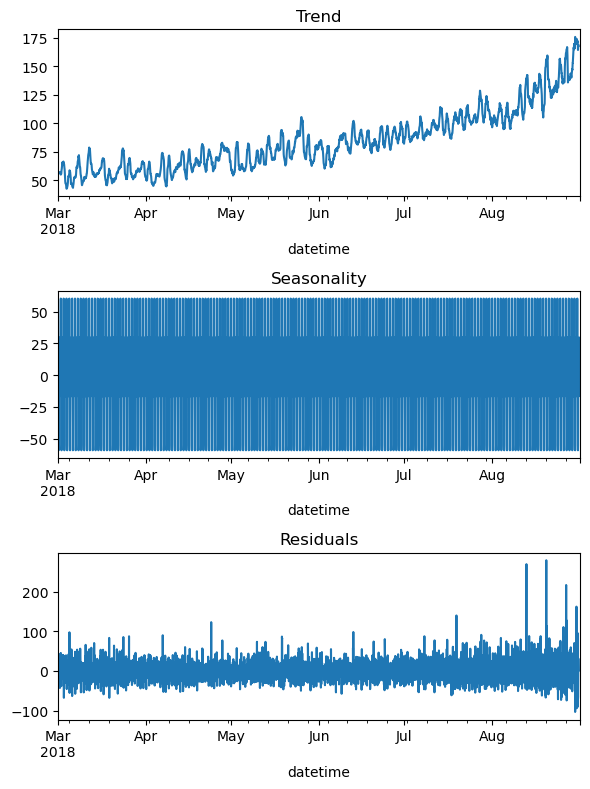

In [14]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

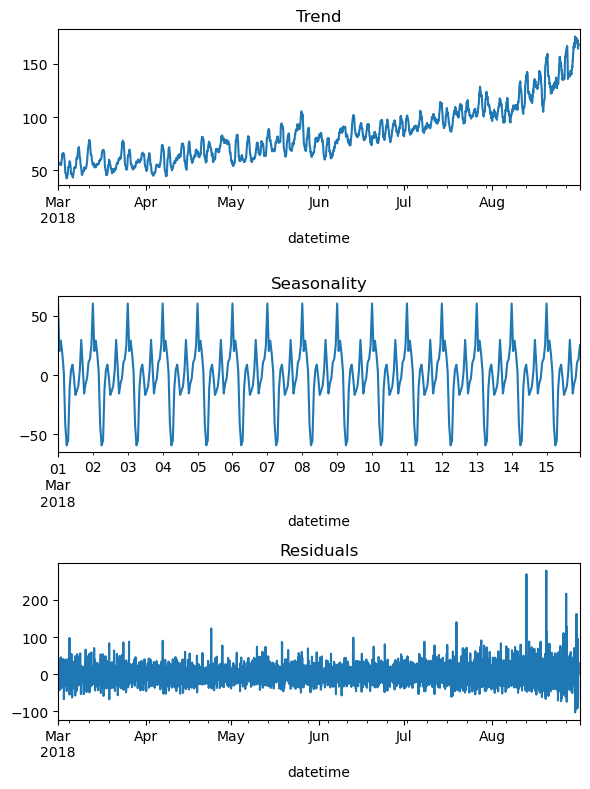

In [15]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

**Вывод:**
- На графиках видно, что сезонность в данном бизнесе отсутствует
- Зато явно присутствует тренд увеличения заказов ближе к осени, т.к у нас данные за один год неполучится сказать, что дальше есть рост или спад

****

### 2. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных. Проверьте данные на тестовой выборке и сделайте выводы.

In [16]:
def make_features(data: pd.DataFrame, 
                  max_lag: int, 
                  rolling_mean_size: int,
                  target: str) -> pd.Series:
    df = data.copy(deep=True)
    df['month'] = data.index.month
    df['day'] = data.index.day
    df['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df[target].shift(lag)

    df['rolling_mean'] = df[target].shift().rolling(rolling_mean_size).mean()
    return df

In [17]:
new_data = make_features(data, 24, 24,  'num_orders')

In [18]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [19]:
new_data

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000
2018-08-31 20:00:00,154,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667
2018-08-31 21:00:00,159,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667


In [20]:
#удалим появившиеся пропуски
new_data.dropna(inplace=True)

In [21]:
#проверим
new_data.isna().sum()

num_orders      0
month           0
day             0
dayofweek       0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
rolling_mean    0
dtype: int64

In [22]:
#разделим на признаки и целевой
X = new_data.drop('num_orders', axis=1)
y = new_data['num_orders']

In [23]:
X.head()

,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,3,2,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,3,2,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


In [24]:
y

datetime
2018-03-02 00:00:00     90
2018-03-02 01:00:00    120
2018-03-02 02:00:00     75
2018-03-02 03:00:00     64
2018-03-02 04:00:00     20
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 4392, dtype: int64

In [25]:
#разделим выборки на train/test/valid
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, random_state=11, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=False, random_state=11, train_size=0.8)

In [26]:
X_train.shape[0] / X.shape[0] * 100, X_test.shape[0] / X.shape[0] * 100, X_val.shape[0] / X.shape[0] * 100

(71.97176684881603, 10.018214936247723, 18.010018214936245)

In [27]:
print('Обучающая выборка:', X_train.shape, y_train.shape)
print('Тестовая выборка:', X_test.shape, y_test.shape)
print('Валидационная выборка:', X_val.shape, y_val.shape)

Обучающая выборка: (3161, 28) (3161,)
Тестовая выборка: (440, 28) (440,)
Валидационная выборка: (791, 28) (791,)


**Вывод:**
- Сделали признаки в виде месяца, дня, дня недели, смещений от 1 до 5 и скользящего среднего
- Разделили данные на train/test/valid в соотношении 70/10/20
- Можем приступать к обучению моделей

****

- Напишем функции, которые будут возвращать оценку по валидации и по тесту

In [28]:
def valid_pipeline(model, actual, pred):
    model = model
    model.fit(X_train, y_train)
    return f'Train: {mean_squared_error(model.predict(pred), actual, squared=False)}'

def test_pipeline(model, actual, pred):
    model = model
    model.fit(X_train, y_train)
    return f'Test: {mean_squared_error(model.predict(pred), actual, squared=False)}'

In [29]:
#валидация регрессия
valid_pipeline(LinearRegression(), y_val, X_val)

'Train: 32.9502947412355'

In [30]:
#валидация дерево
valid_pipeline(DecisionTreeRegressor(random_state=1), y_val, X_val)

'Train: 44.888188102215416'

In [31]:
tscv = TimeSeriesSplit(n_splits=5)
parameters = {'criterion':('squared_error', 'friedman_mse', 'absolute_error', 'poisson'), 
              'max_features': ('sqrt', 'log2'),
              'max_depth': range(2, 25, 2)}

grid = GridSearchCV(DecisionTreeRegressor(random_state=1), parameters, cv = tscv, n_jobs=-1)
valid_pipeline(grid, y_val, X_val)

'Train: 42.850993031458586'

- По итогу с хорошим отрывом оказалась линейная регрессия, поэтому предлагаю оставить ее

In [32]:
#тест регрессия
test_pipeline(LinearRegression(), y_test, X_test)

'Test: 46.68964620661836'

In [33]:
#соберем финальные предсказания
final_model = LinearRegression()
final_model.fit(X_train, y_train)
final_pred = final_model.predict(X_test)

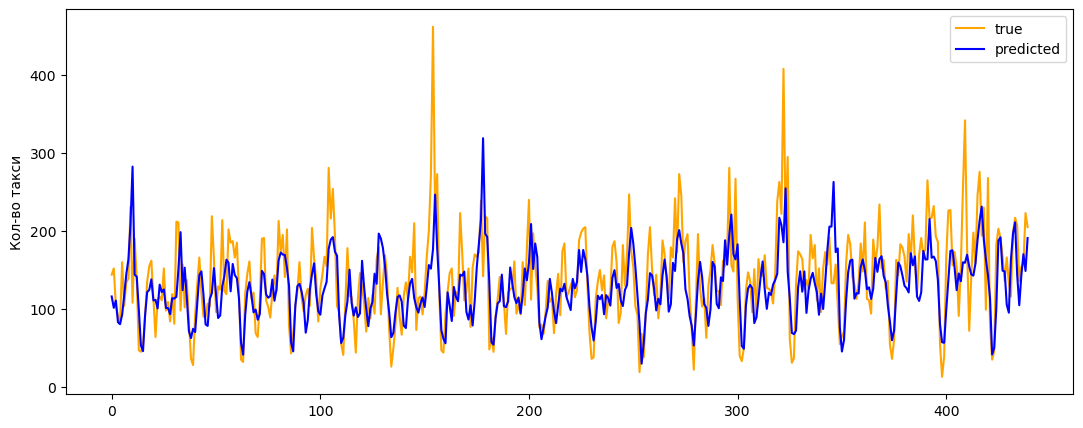

In [34]:
#построим график
fig, ax = plt.subplots(figsize=[13,5])
plt.plot(y_test.values, label='true', color='orange')
plt.plot(final_pred, label='predicted', color='blue')
plt.ylabel('Кол-во такси')
plt.legend()
plt.show()

**Вывод:**
- На графике видно, что модель ориентируется на 'средний' диапазон значений, и недостаточно хорошо ориентируется на больших значениях

## Общий вывод:
- Познакомились с данными
- Сделали ресемплирование
- Разделили данные
- Обучили модели и сделали предсказание:
| Model       |RMSE - Valid|  RMSE - Test     |
| ----------- | -----------| ---------        |
| LinearRegression         |  32.95    | 46.68  |
| DecisionTreeRegressor    | 42.85     | X |

**По итогу предлагаю остановить свой выбор на линейной регрессии т.к результат на тесте лучше, и удовлетворяет условиям заказа быть менее 48**